# Supporting Notebook 1 (Clustering Similar Stocks)


In this notebook, we want to explore ways to find similar stocks. After starting this work, others (see ["Pairs trading with machine learing"](https://www.quantopian.com/posts/pairs-trading-with-machine-learning) ) appear to have had the same idea and our work has some similarities with theirs.

Below you see a sample visualization of stocks using this notebook. For example, in the bottom right corner you see a cluster with:
- BMW
- Daimler
- Porshe
- Continental
- Volkswagen

We can also see a cluster with:
- Telefonica
- Vodafone
- Deutche Telecom

Be aware that the results depend on the time period in which the clustering was done, the discretization interval (e.g. 15 minutes) and other factors as described below.

In [46]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "stock_clusters.png")

A technique such as this would be useful for:

- finding stocks that behave similarly (or dissimilarly) to one of interest
- building trading strategies
- identifying anomalies (e.g. if two stocks are normally correlated but fall out of line in a particular day, you might want to investigate)
- discarding bad stocks (if stocks do not correlate with other stocks they might need investigating).


In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import hdbscan
import time
import seaborn as sns
import collections
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5, 3) # use bigger graphs

As in previous notebooks we load the prepared data.

In [2]:
input_file = '/data/cooked_v3.pkl'
df = pd.read_pickle(input_file)
df['CalcDateTime'] = df.index
df['Date'] = df['CalcDateTime'].dt.strftime("%Y-%m-%d")

## Methodology

1. Select a time frame within which to analyze the stocks.
- Select an interval within which to aggregate the prices (e.g. 10 minutes, 1 day).
- Select a function of the price such as percent change or log returns.
- Select a similarity function between the timeseries, such as dot product, cosine or correlation coefficient.
- Select a clustering algorithm.
- Visualize the results.

In [3]:
def date_part(dt):
    return str(dt).split(' ')[0]

unique_days = sorted(list(set(map(date_part , list(df.index.unique())))))
len(unique_days), unique_days[0:2], unique_days[-3:-1]

(200, ['2017-07-03', '2017-07-04'], ['2018-04-26', '2018-04-27'])

In [4]:
selected_days = unique_days[0:60]
subset_df = df[df.Date.isin(list(selected_days))]

In [5]:
def prepare_single_stock(df, mnemonic, interval):
    single_stock = df[df.Mnemonic == mnemonic].copy()
    single_stock['StartEndPrice'] = 0.5*(single_stock['StartPrice'] + single_stock['EndPrice'])
    single_stock['MaxMinPrice'] = 0.5*(single_stock['MaxPrice'] + single_stock['MinPrice'])
    single_stock['Avg4Price'] = 0.25*(single_stock['MaxPrice'] + single_stock['MinPrice'] + 
                                      single_stock['StartPrice'] + single_stock['EndPrice'])
    
    resampled = pd.DataFrame({
        'MeanAvg4Price': single_stock['Avg4Price'].resample(interval).mean(),          
        'HasTrade': single_stock['HasTrade'].resample(interval).max(),
        'Mnemonic': mnemonic,
    })
    resampled['PctChange'] = resampled['MeanAvg4Price'].pct_change().fillna(0.0)
    resampled = resampled[resampled.HasTrade == 1.0]
    return resampled[['Mnemonic', 'PctChange', 'MeanAvg4Price']]
mnemonics = subset_df['Mnemonic'].unique()
mnemonics

array(['SNH', 'DBK', 'EOAN', 'DTE', 'CBK', 'RWE', 'IFX', 'SVAB', 'LHA',
       'DAI', 'O2D', 'TKA', 'DPW', 'HDD', 'SIE', 'AIXA', 'BAYN', 'SAP',
       'BAS', 'EVT', 'AT1', 'PSM', 'BMW', 'VOW3', 'FRE', 'GAZ', 'SDF',
       'CEC', 'ALV', 'VNA', 'B4B', 'SHA', 'AB1', 'UN01', 'DLG', 'NDX1',
       'NOA3', 'IGY', 'VODI', 'ADS', '1COV', 'TUI1', 'BPE5', 'HEI', 'KCO',
       'ADV', 'SZU', 'EVK', 'HEN3', 'WDI', 'MUV2', 'DWNI', 'MRK', 'USE',
       'PAH3', 'DEZ', 'FME', 'G1A', 'FNTN', 'RKET', 'QIA', 'DB1', 'ZAL',
       'QSC', 'CON', 'SGL', 'BVB', 'TINA', 'PBB', 'PNE3', 'RIB', 'OSR',
       'SHL', 'AOX', 'BEI', 'TEG', 'UTDI', 'ARL', 'MDG1', 'KGX', 'LXS',
       'ARO', 'TTI', 'SANT', 'GYC', 'ANO', 'LINU', 'SOW', 'SZG', 'LLD',
       'BOSS', 'BNR', 'WAF', 'LIN', 'DRI', 'NDA', 'ZIL2', 'SY1', 'CAP',
       '3W9K'], dtype=object)

In [6]:
mnemonic_2_desc = {
    '1COV': 'COVESTRO AG  O.N.',
     '3W9K': '3W POWER S.A. EO -,01',
     'AB1': 'AIR BERLIN PLC    EO -,25',
     'ADS': 'ADIDAS AG NA O.N.',
     'ADV': 'ADVA OPT.NETW.SE  O.N.',
     'AIXA': 'AIXTRON SE NA O.N.',
     'ALV': 'ALLIANZ SE NA O.N.',
     'AOX': 'ALSTRIA OFFICE REIT-AG',
     'ARL': 'AAREAL BANK AG',
     'AT1': 'AROUNDTOWN EO-,01',
     'B4B': 'METRO AG   ST O.N.',
     'BAS': 'BASF SE NA O.N.',
     'BAYN': 'BAYER AG NA O.N.',
     'BEI': 'BEIERSDORF AG O.N.',
     'BMW': 'BAY.MOTOREN WERKE AG ST',
     'BNR': 'BRENNTAG AG NA O.N.',
     'BOSS': 'HUGO BOSS AG NA O.N.',
     'BPE5': 'BP PLC             DL-,25',
     'BVB': 'BORUSSIA DORTMUND',
     'CAP': 'ENCAVIS AG  INH. O.N.',
     'CBK': 'COMMERZBANK AG',
     'CEC': 'CECONOMY AG  ST O.N.',
     'CON': 'CONTINENTAL AG O.N.',
     'DAI': 'DAIMLER AG NA O.N.',
     'DB1': 'DEUTSCHE BOERSE NA O.N.',
     'DBK': 'DEUTSCHE BANK AG NA O.N.',
     'DEZ': 'DEUTZ AG O.N.',
     'DLG': 'DIALOG SEMICOND.   LS-,10',
     'DPW': 'DEUTSCHE POST AG NA O.N.',
     'DRI': '1+1 DRILLISCH AG O.N.',
     'DTE': 'DT.TELEKOM AG NA',
     'DWNI': 'DEUTSCHE WOHNEN SE INH',
     'EOAN': 'E.ON SE NA O.N.',
     'EVK': 'EVONIK INDUSTRIES NA O.N.',
     'EVT': 'EVOTEC AG O.N.',
     'FME': 'FRESEN.MED.CARE KGAA O.N.',
     'FNTN': 'FREENET AG NA O.N.',
     'FRE': 'FRESENIUS SE+CO.KGAA O.N.',
     'G1A': 'GEA GROUP AG',
     'GAZ': 'GAZPROM ADR SP./2 RL 5L 5',
     'GYC': 'GRAND CITY PROPERT.EO-,10',
     'HDD': 'HEIDELBERG.DRUCKMA.O.N.',
     'HEI': 'HEIDELBERGCEMENT AG O.N.',
     'HEN3': 'HENKEL AG+CO.KGAA VZO',
     'IFX': 'INFINEON TECH.AG NA O.N.',
     'IGY': 'INNOGY SE  INH. O.N.',
     'KCO': 'KLOECKNER + CO SE NA O.N.',
     'KGX': 'KION GROUP AG',
     'LHA': 'LUFTHANSA AG VNA O.N.',
     'LIN': 'LINDE AG O.N.',
     'LINU': 'LINDE AG O.N. Z.UMT.',
     'LLD': 'LLOYDS BKG GRP     LS-,10',
     'LXS': 'LANXESS AG',
     'MDG1': 'MEDIGENE AG NA O.N.',
     'MRK': 'MERCK KGAA O.N.',
     'MUV2': 'MUENCH.RUECKVERS.VNA O.N.',
     'NDA': 'AURUBIS AG',
     'NDX1': 'NORDEX SE O.N.',
     'NOA3': 'NOKIA OYJ EO-,06',
     'O2D': 'TELEFONICA DTLD HLDG NA',
     'OSR': 'OSRAM LICHT AG NA O.N.',
     'PAH3': 'PORSCHE AUTOM.HLDG VZO',
     'PBB': 'DT.PFANDBRIEFBK AG',
     'PNE3': 'PNE WIND AG NA O.N.',
     'PSM': 'PROSIEBENSAT.1  NA O.N.',
     'QIA': 'QIAGEN NV         EO -,01',
     'QSC': 'QSC AG NA O.N.',
     'RIB': 'RIB SOFTWARE SE  NA EO 1',
     'RKET': 'ROCKET INTERNET SE',
     'RWE': 'RWE AG ST O.N.',
     'SANT': 'S+T AG (Z.REG.MK.Z.)O.N.',
     'SAP': 'SAP SE O.N.',
     'SDF': 'K+S AG NA O.N.',
     'SGL': 'SGL CARBON SE O.N.',
     'SHA': 'SCHAEFFLER AG INH. VZO',
     'SHL': 'SIEMENS HEALTH.AG NA O.N.',
     'SIE': 'SIEMENS AG NA',
     'SNH': 'STEINHOFF INT.HLDG.EO-,50',
     'SOW': 'SOFTWARE AG  NA O.N.',
     'SVAB': 'STOCKHOLM IT VENTURES AB',
     'SY1': 'SYMRISE AG INH. O.N.',
     'SZG': 'SALZGITTER AG O.N.',
     'SZU': 'SUEDZUCKER AG  O.N.',
     'TEG': 'TAG IMMOBILIEN AG',
     'TKA': 'THYSSENKRUPP AG O.N.',
     'TTI': 'TOM TAILOR HLDG  NA O.N.',
     'TUI1': 'TUI AG NA O.N.',
     'UN01': 'UNIPER SE  NA O.N.',
     'USE': 'BEATE UHSE AG',
     'UTDI': 'UTD.INTERNET AG NA',
     'VNA': 'VONOVIA SE NA O.N.',
     'VODI': 'VODAFONE GROUP PLC',
     'VOW3': 'VOLKSWAGEN AG VZO O.N.',
     'WAF': 'SILTRONIC AG NA O.N.',
     'WDI': 'WIRECARD AG',
     'ZAL': 'ZALANDO SE',
     'ZIL2': 'ELRINGKLINGER AG NA O.N.',
     'TINA': 'TINA',
     'ANO': 'ANO',
     'ARO': 'ARO'                   
}

In [7]:
single_stocks_dfs = []

interval = '60Min'

for mnemonic in mnemonics:
    single_stock = prepare_single_stock(subset_df, mnemonic, interval)
    single_stocks_dfs.append(single_stock)

# the dataframe for clustering    
clustering_df = pd.concat(single_stocks_dfs, axis=0)
clustering_df['CalcDateTime'] = clustering_df.index

In [8]:
clustering_df.head()

,Mnemonic,PctChange,MeanAvg4Price,CalcDateTime
CalcDateTime,,,,
2017-07-03 08:00:00,SNH,0.000000,4.460471,2017-07-03 08:00:00
2017-07-03 09:00:00,SNH,0.000524,4.462808,2017-07-03 09:00:00
2017-07-03 10:00:00,SNH,0.008449,4.500512,2017-07-03 10:00:00
2017-07-03 11:00:00,SNH,0.006072,4.527838,2017-07-03 11:00:00
2017-07-03 12:00:00,SNH,0.000075,4.528175,2017-07-03 12:00:00


In [9]:
cluster_by_feature = 'PctChange' # this is also possible
subset = clustering_df.pivot(index='CalcDateTime', columns='Mnemonic', values=cluster_by_feature)
corr_mat = subset.corr().fillna(0.0)
corr_mat.head()

Mnemonic,1COV,3W9K,AB1,ADS,ADV,AIXA,ALV,ANO,AOX,ARL,...,UN01,USE,UTDI,VNA,VODI,VOW3,WAF,WDI,ZAL,ZIL2
Mnemonic,,,,,,,,,,,,,,,,,,,,,
1COV,1.000000,0.048965,0.015822,0.035523,0.032499,0.173607,0.448280,0.108518,0.219470,0.274090,...,0.192464,0.015148,0.276918,0.211907,0.256222,0.217871,0.211186,0.101065,0.207686,0.090076
3W9K,0.048965,1.000000,0.061478,0.136542,-0.012191,0.092599,0.143738,0.020394,0.034827,0.091008,...,0.090111,-0.355021,-0.061778,-0.027660,0.109736,-0.038468,0.055208,0.030829,0.125867,0.095154
AB1,0.015822,0.061478,1.000000,0.007969,0.066823,0.226705,-0.030050,0.051273,0.018297,-0.069767,...,0.090725,0.124877,0.015534,0.079739,-0.140695,-0.103210,0.163032,0.020541,0.076912,0.050893
ADS,0.035523,0.136542,0.007969,1.000000,0.053431,0.094512,0.132458,-0.074142,0.077855,0.077573,...,0.009460,0.072037,0.096356,0.070037,0.130684,0.021549,0.113116,0.121943,0.144174,0.053607
ADV,0.032499,-0.012191,0.066823,0.053431,1.000000,0.097387,0.233218,0.004022,0.187164,0.142589,...,0.181224,0.021717,0.274105,0.093829,0.214735,0.227708,0.049017,0.134347,0.092583,0.137238


In [10]:
def find_most_correlated(corr_mat, mnemonic, n=10):
    results = corr_mat[[mnemonic]].sort_values(mnemonic, ascending=False).head(n).copy()
    results['Desc'] = map(lambda m: mnemonic_2_desc[m], list(results.index))
    results['Corr'] = results[mnemonic]
    return results[['Desc', 'Corr']]

find_most_correlated(corr_mat, 'BMW')

Mnemonic,Desc,Corr
Mnemonic,,
BMW,BAY.MOTOREN WERKE AG ST,1.000000
DAI,DAIMLER AG NA O.N.,0.810825
PAH3,PORSCHE AUTOM.HLDG VZO,0.762627
VOW3,VOLKSWAGEN AG VZO O.N.,0.746777
CON,CONTINENTAL AG O.N.,0.599425
BAS,BASF SE NA O.N.,0.430759
DPW,DEUTSCHE POST AG NA O.N.,0.427840
BAYN,BAYER AG NA O.N.,0.426127
ZIL2,ELRINGKLINGER AG NA O.N.,0.416700


In [11]:
find_most_correlated(corr_mat, 'ZAL')

Mnemonic,Desc,Corr
Mnemonic,,
ZAL,ZALANDO SE,1.000000
NOA3,"NOKIA OYJ EO-,06",0.367431
ALV,ALLIANZ SE NA O.N.,0.346885
BMW,BAY.MOTOREN WERKE AG ST,0.322760
DPW,DEUTSCHE POST AG NA O.N.,0.314061
IFX,INFINEON TECH.AG NA O.N.,0.312548
KGX,KION GROUP AG,0.288901
VOW3,VOLKSWAGEN AG VZO O.N.,0.286392
BPE5,"BP PLC DL-,25",0.284564


In [12]:
find_most_correlated(corr_mat, 'DB1')

Mnemonic,Desc,Corr
Mnemonic,,
DB1,DEUTSCHE BOERSE NA O.N.,1.000000
BAS,BASF SE NA O.N.,0.522488
BAYN,BAYER AG NA O.N.,0.489341
DLG,"DIALOG SEMICOND. LS-,10",0.429095
DBK,DEUTSCHE BANK AG NA O.N.,0.416107
MUV2,MUENCH.RUECKVERS.VNA O.N.,0.399725
SAP,SAP SE O.N.,0.398477
DPW,DEUTSCHE POST AG NA O.N.,0.396724
IFX,INFINEON TECH.AG NA O.N.,0.395663


In [13]:
find_most_correlated(corr_mat, 'SAP')

Mnemonic,Desc,Corr
Mnemonic,,
SAP,SAP SE O.N.,1.000000
DPW,DEUTSCHE POST AG NA O.N.,0.607967
IFX,INFINEON TECH.AG NA O.N.,0.586449
BAS,BASF SE NA O.N.,0.574498
BAYN,BAYER AG NA O.N.,0.573304
UTDI,UTD.INTERNET AG NA,0.566911
FRE,FRESENIUS SE+CO.KGAA O.N.,0.558952
ALV,ALLIANZ SE NA O.N.,0.546060
FME,FRESEN.MED.CARE KGAA O.N.,0.530520


In [14]:
enable_truncated_svd = False
if enable_truncated_svd:
    #corr_mat = orig_corr_mat
    reduced_corr_mat = TruncatedSVD(n_components=20, random_state=478870).fit_transform(corr_mat)
    tmp_corr_mat = pd.DataFrame(reduced_corr_mat)
    tmp_corr_mat.index = list(corr_mat.index)
    # uncomment to swap the correlation matrix
    orig_corr_mat = corr_mat
    corr_mat = tmp_corr_mat

In [15]:
class Cluster:
    def __init__(self, cluster_id, members):
        self.cluster_id = cluster_id
        self.members = members
        
    def __repr__(self):
        return "Cluster {}:".format(self.cluster_id) + " " + ", ".join(self.members)
        
def build_clusters(data, algorithm, args, kwds, names):
    membership_labels = algorithm(*args, **kwds).fit_predict(data)
    d = collections.defaultdict(list)
    i = 0
    for label in membership_labels:
        d[label].append(names[i])
        i += 1
    clusters = []
    for k,v in d.items():
        clusters.append(Cluster(k, v))
    return membership_labels, clusters


friendly_labels = []

def truncate_str(v):
    t = 12
    if len(v) <= t:
        return v
    return v[0:10] + "..."

for m in list(corr_mat.index):
    friendly_labels.append("{}({})".format(m, truncate_str(mnemonic_2_desc[m])))
   
membership_labels, clusters = build_clusters(corr_mat, hdbscan.HDBSCAN, (), {'min_cluster_size':2}, friendly_labels)

In [16]:
clusters

[Cluster 0: AB1(AIR BERLIN...), ANO(ANO), SVAB(STOCKHOLM ...),
 Cluster 1: CAP(ENCAVIS AG...), TINA(TINA),
 Cluster 2: ADS(ADIDAS AG ...), G1A(GEA GROUP AG),
 Cluster 3: SHA(SCHAEFFLER...), SZU(SUEDZUCKER...),
 Cluster 4: EVT(EVOTEC AG ...), HDD(HEIDELBERG...),
 Cluster 5: AOX(ALSTRIA OF...), DWNI(DEUTSCHE W...), GYC(GRAND CITY...), TEG(TAG IMMOBI...), VNA(VONOVIA SE...), WAF(SILTRONIC ...),
 Cluster 6: DEZ(DEUTZ AG O...), SANT(S+T AG (Z....), SGL(SGL CARBON...),
 Cluster 7: AIXA(AIXTRON SE...), BVB(BORUSSIA D...), MDG1(MEDIGENE A...), SOW(SOFTWARE A...), WDI(WIRECARD AG),
 Cluster 8: BMW(BAY.MOTORE...), CON(CONTINENTA...), DAI(DAIMLER AG...), PAH3(PORSCHE AU...), VOW3(VOLKSWAGEN...),
 Cluster 9: 1COV(COVESTRO A...), NDA(AURUBIS AG),
 Cluster 10: ARL(AAREAL BAN...), CBK(COMMERZBAN...), DB1(DEUTSCHE B...), DBK(DEUTSCHE B...), PBB(DT.PFANDBR...), RKET(ROCKET INT...),
 Cluster 11: MRK(MERCK KGAA...), QIA(QIAGEN NV ...),
 Cluster 12: EOAN(E.ON SE NA...), IGY(INNOGY SE ...), RWE(RWE AG ST .

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.000s...
[t-SNE] Computed neighbors for 99 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 0.622257
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 56.5626717, gradient norm = 0.4928769 (50 iterations in 0.072s)
[t-SNE] Iteration 100: error = 57.0891075, gradient norm = 0.5587064 (50 iterations in 0.053s)
[t-SNE] Iteration 150: error = 58.0914230, gradient norm = 0.5004117 (50 iterations in 0.047s)
[t-SNE] Iteration 200: error = 58.9739265, gradient norm = 0.5230210 (50 iterations in 0.052s)
[t-SNE] Iteration 250: error = 57.7468262, gradient norm = 0.4865134 (50 iterations in 0.049s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.746826
[t-SNE] Iteration 300: error = 0.6788524, gradient norm = 0.0060844 (50 iterations in 0.046s)
[t-SNE] Iteration 350: error = 0.6168142, gradient norm = 0.0056921 (50 i

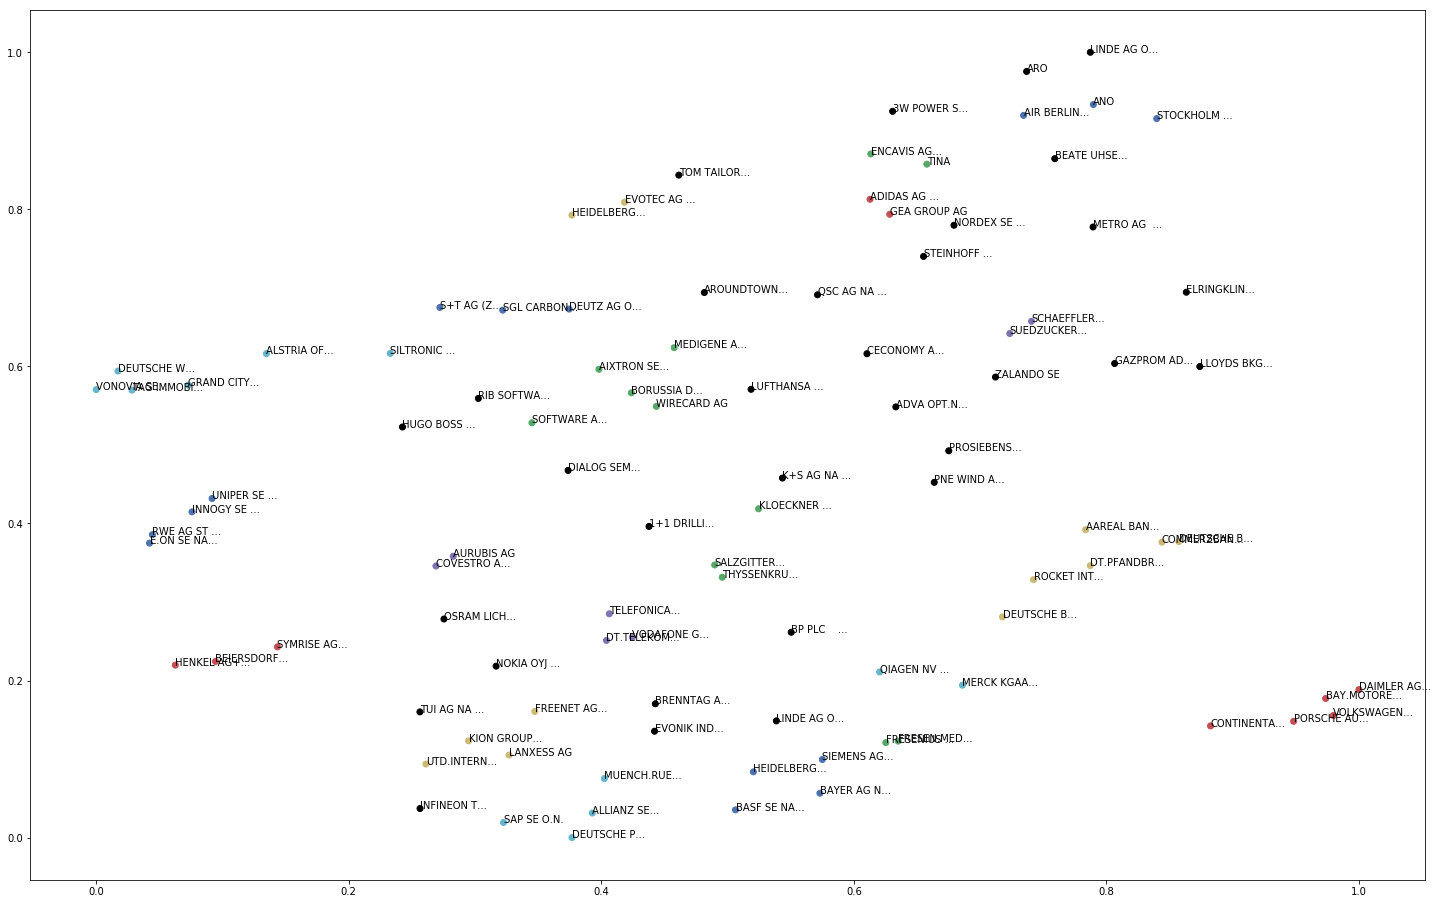

In [37]:
mpl.rcParams['figure.figsize'] = (25, 16) # use bigger graphs

model = TSNE(n_components=2, perplexity=25, verbose=2, random_state=686861).fit_transform(corr_mat)

x_axis=model[:,0]
y_axis=model[:,1]
x_norm = (x_axis-np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis-np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

fig, ax = plt.subplots()
palette = sns.color_palette('deep', np.unique(membership_labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in membership_labels]
    
ax.scatter(x_norm, y_norm, c = colors)
names = list(corr_mat.index)

for i, name in enumerate(names):
    ax.annotate(truncate_str(mnemonic_2_desc[name]), (x_norm[i],y_norm[i]))    